<a href="https://colab.research.google.com/github/achrafz001/Big_Data_Mini_projet/blob/main/Big_Data_Miniprojet_MCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Before starting:**

You need to install Basemap. You have to do it at each new session.

In [ ]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 864 kB 8.6 MB/s 
     |████████████████████████████████| 6.3 MB 43.6 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 30.5 MB 96.0 MB/s 


In [ ]:
"""%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip"""

'%%bash\napt-get install libgeos-3* libgeos-dev\npip install https://github.com/matplotlib/basemap/archive/master.zip'

**Goal of this practice:**

The goal is to use a cloud computing platform (the Google Cloud Platform). We will use big data tools on Colab to process large datasets. These data are real satellite observations of the ocean (5 years).

**Evaluation of this practice:**

I will evaluate 3 main components.

The first is the quality of the code. It must be concise and well written. The goal is to manipulate big data tools provided by the Google Cloud Platform (such as BigQuery).

The second is the quality of the outputs. Never forget that you are dealing with physical variables evolving in space and time. You must use maps and time series. You must also write the units (e.g., °C, m).

The third thing is the discussion about your results. Again, remember that you are dealing with oceanographic data. They have a physical meaning and you should be able to comment the outputs.

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [ ]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [ ]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,SST,line_type,var_name):

    # plot
    plot_date(time,SST,line_type)
    xlabel('Time (days)',fontsize=15)
    ylabel(var_name,fontsize=15)

In [ ]:
# download data from dropbox directly (less time from regular method !)
!wget -O data_sst_ssh_2015_small.csv https://www.dropbox.com/s/4hs50v69oe9x7ti/data_sst_ssh_2015_small.csv?dl=0

--2022-10-24 18:11:45--  https://www.dropbox.com/s/4hs50v69oe9x7ti/data_sst_ssh_2015_small.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/4hs50v69oe9x7ti/data_sst_ssh_2015_small.csv [following]
--2022-10-24 18:11:46--  https://www.dropbox.com/s/raw/4hs50v69oe9x7ti/data_sst_ssh_2015_small.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04473fdd3a7ea68d0c4a008f60.dl.dropboxusercontent.com/cd/0/inline/BvfO1AjGBRYeZ6IdS5jxOfT-M83YKHPDPaQW-RZvyx63ukV5iyLSn1FPL168D6zI-ZiNwGv1z7ezBZ0LfmQacB55wO7HPfNu4xC4D2hxDJV6m6nl_aPzFwlVhRPUM-UZBrR2EV8XUVDhg_DEIxRLvTaKALAT6kbO9QpaIIGmjA54Dw/file# [following]
--2022-10-24 18:11:46--  https://uc04473fdd3a7ea68d0c4a008f60.dl.dropboxusercontent.com/cd/0/inline/BvfO1AjGBRYeZ6IdS5jxOfT-M83YK

**The satellite database:**

In this practice, we use 5 years (2011-2015) of satellite observations of the global ocean. We use daily data with 25km spatial resolution. We study the Sea Surface Temperature (SST, in degrees) and the Sea Surface Height (SSH, in meters). SST and SSH are indexed in space (lon, lat) and time. The full database is stored in csv files and is quite large (~50Go).

**Part 1) Manipulation of a small dataset using pandas:**

We start to work on a small database (only the 10 first days in 2015, ~250Mo) and we will perform some basic statistics. The idea is to show that even if you use a small sample, basic data manipulation without big data tools is difficult, time and resource consuming.

After copying the dataset "data_sst_ssh_2015_small.csv" on your Colab environment, we read it using pandas (easy-to-use data structures and data analysis tools). We use the *groupby* and *mean* pandas functions to: map the global SST and SSH (using *plot_im*), plot the mean SST and SSH time series (using *plot_ts*).

In [ ]:
# read dataframe
data = pd.read_csv('data_sst_ssh_2015_small.csv', header=None, names=['lat', 'lon', 'sst', 'time', 'ssh'])

In [ ]:
# sample of the dataset
data[data['lon'] == 17.125 ][ data['lat'] == 31.875]

lat     lon    sst      time     ssh
446109   31.875  17.125  19.35  735600.0  0.0892
979077   31.875  17.125  19.50  735601.0  0.1015
1512406  31.875  17.125  19.50  735602.0  0.1054
2045765  31.875  17.125  18.90  735603.0  0.1079
2579607  31.875  17.125  19.20  735604.0  0.1128
3113645  31.875  17.125  19.05  735605.0  0.1100
3647681  31.875  17.125  19.35  735606.0  0.1063
4182071  31.875  17.125  18.90  735607.0  0.0996
4716956  31.875  17.125  18.90  735608.0  0.0958
5252539  31.875  17.125  19.05  735609.0  0.0857

In [ ]:
# statistics of the dataset
data.describe()

lat           lon           sst          time           ssh
count  5.338143e+06  5.338143e+06  5.338143e+06  5.338143e+06  5.338142e+06
mean  -1.140247e+01  1.932643e+02  1.646710e+01  7.356045e+05  3.436659e-01
std    3.845651e+01  1.003294e+02  1.041889e+01  2.871929e+00  7.254869e-01
min   -7.762500e+01  1.250000e-01 -1.800000e+00  7.356000e+05 -1.520300e+00
25%   -4.462500e+01  1.123750e+02  6.450000e+00  7.356020e+05 -3.170000e-02
50%   -1.587500e+01  1.971250e+02  1.950000e+01  7.356050e+05  5.697000e-01
75%    1.737500e+01  2.733750e+02  2.595000e+01  7.356070e+05  8.530000e-01
max    8.437500e+01  3.598750e+02  3.345000e+01  7.356090e+05  1.898000e+00

Geostationary, Orthographic or Azimuthal equidistant basemapWarning: Cannot label parallels on Orthographic basemap'Warning: Cannot label meridians on full-disk
Geostationary, Orthographic or Azimuthal equidistant basemap

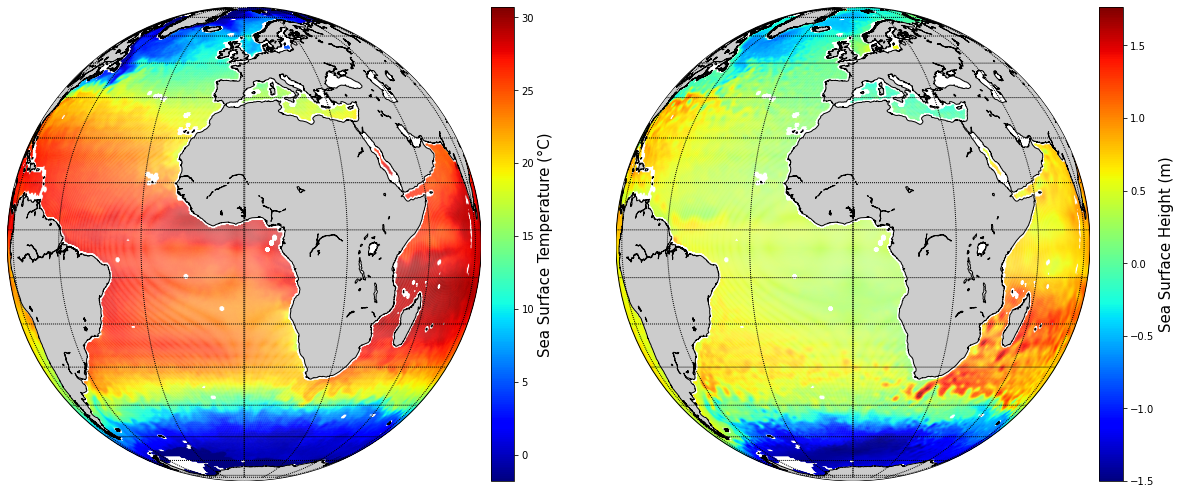

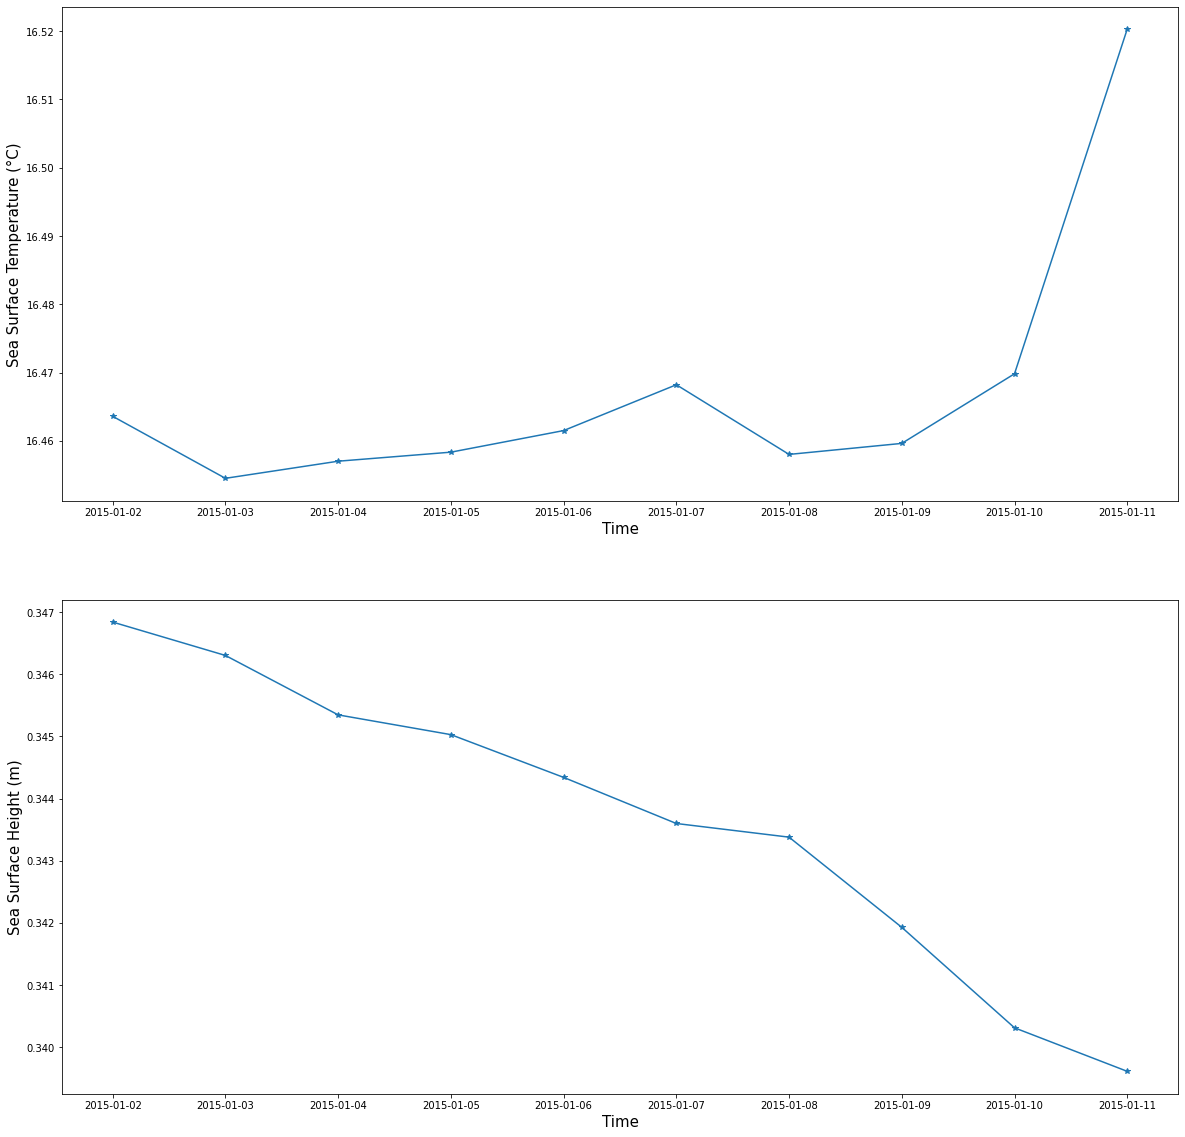

In [ ]:
# plot global SST and SSH maps
sst_im=data.groupby(['lon','lat'])['sst'].mean()
ssh_im=data.groupby(['lon','lat'])['ssh'].mean()
lon_im=data.groupby(['lon','lat'])['lon'].mean()
lat_im=data.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_im,lat_im,sst_im,1,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_im,lat_im,ssh_im,1,'Sea Surface Height (m)')

# plot global SST and SSH time series
sst_ts=data.groupby(['time'])['sst'].mean()
ssh_ts=data.groupby(['time'])['ssh'].mean()
time_ts=data.groupby(['time'])['time'].mean() #dropout repititions
figure()
subplot(2,1,1)
plot_ts(time_ts,sst_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_ts,ssh_ts,'-*','Sea Surface Height (m)')

Now, we consider only a small region of the Globe: the Mediterranean Sea. As previously, we plot the mean time series and maps of SST and SSH. We also plot the SSH as a function of SST and the 2 distributions using histograms.

Text(0, 0.5, 'Sea Surface Height (m)')

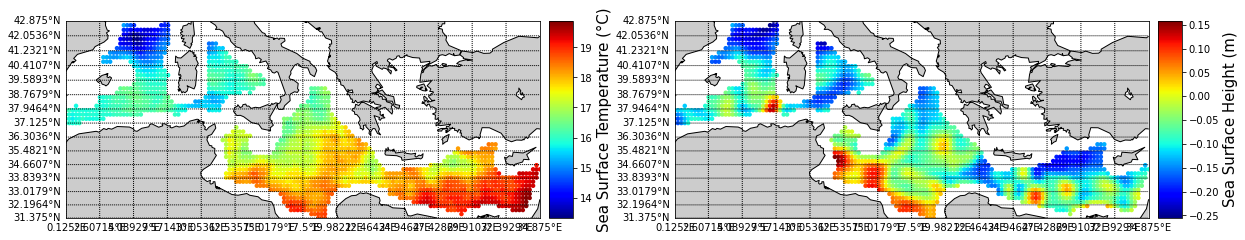

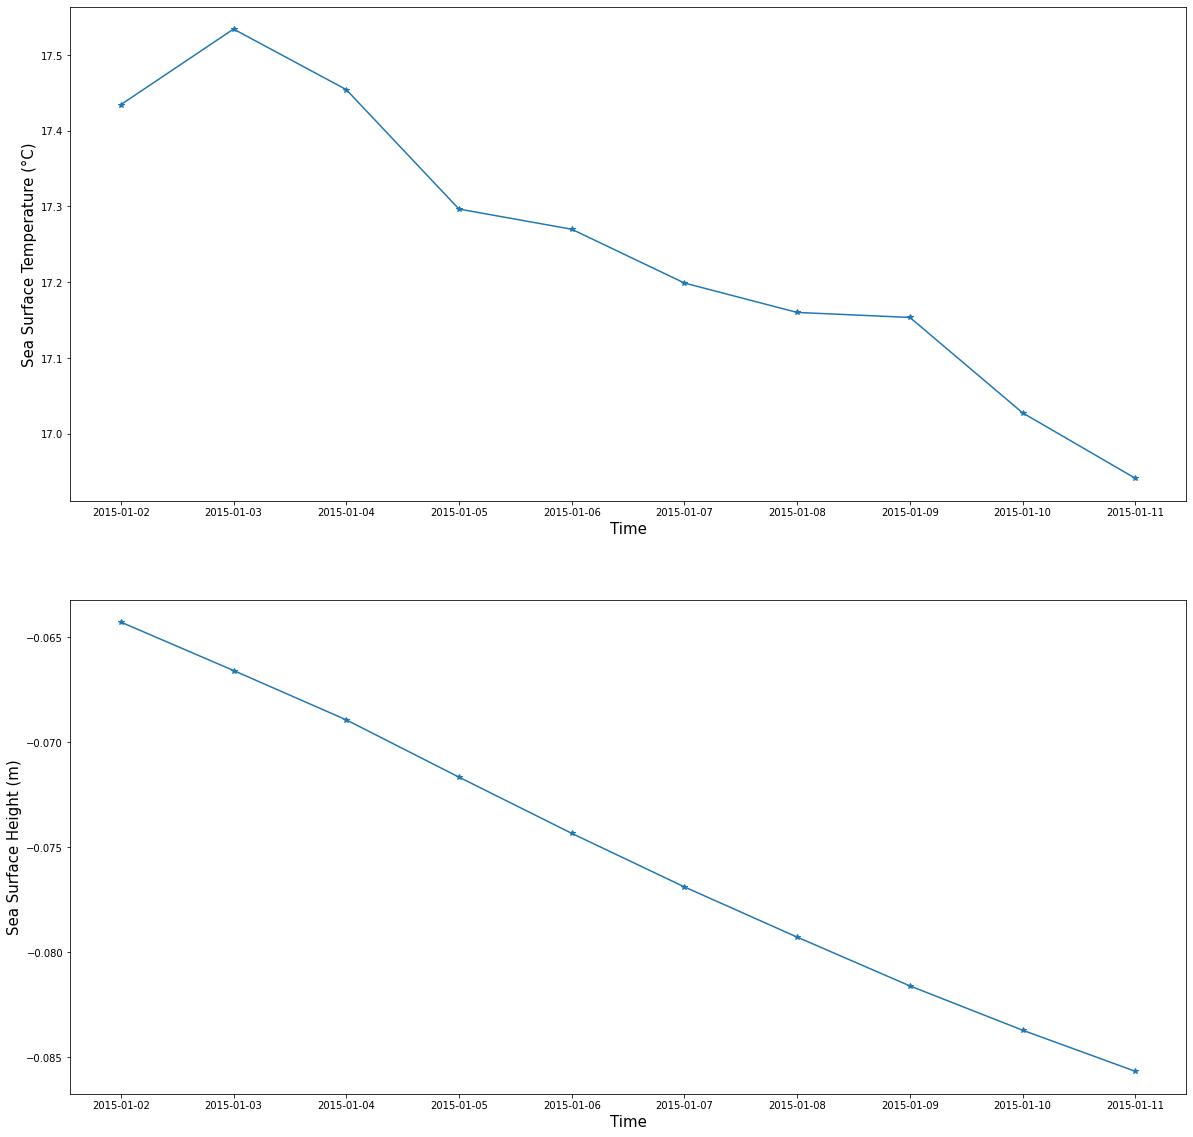

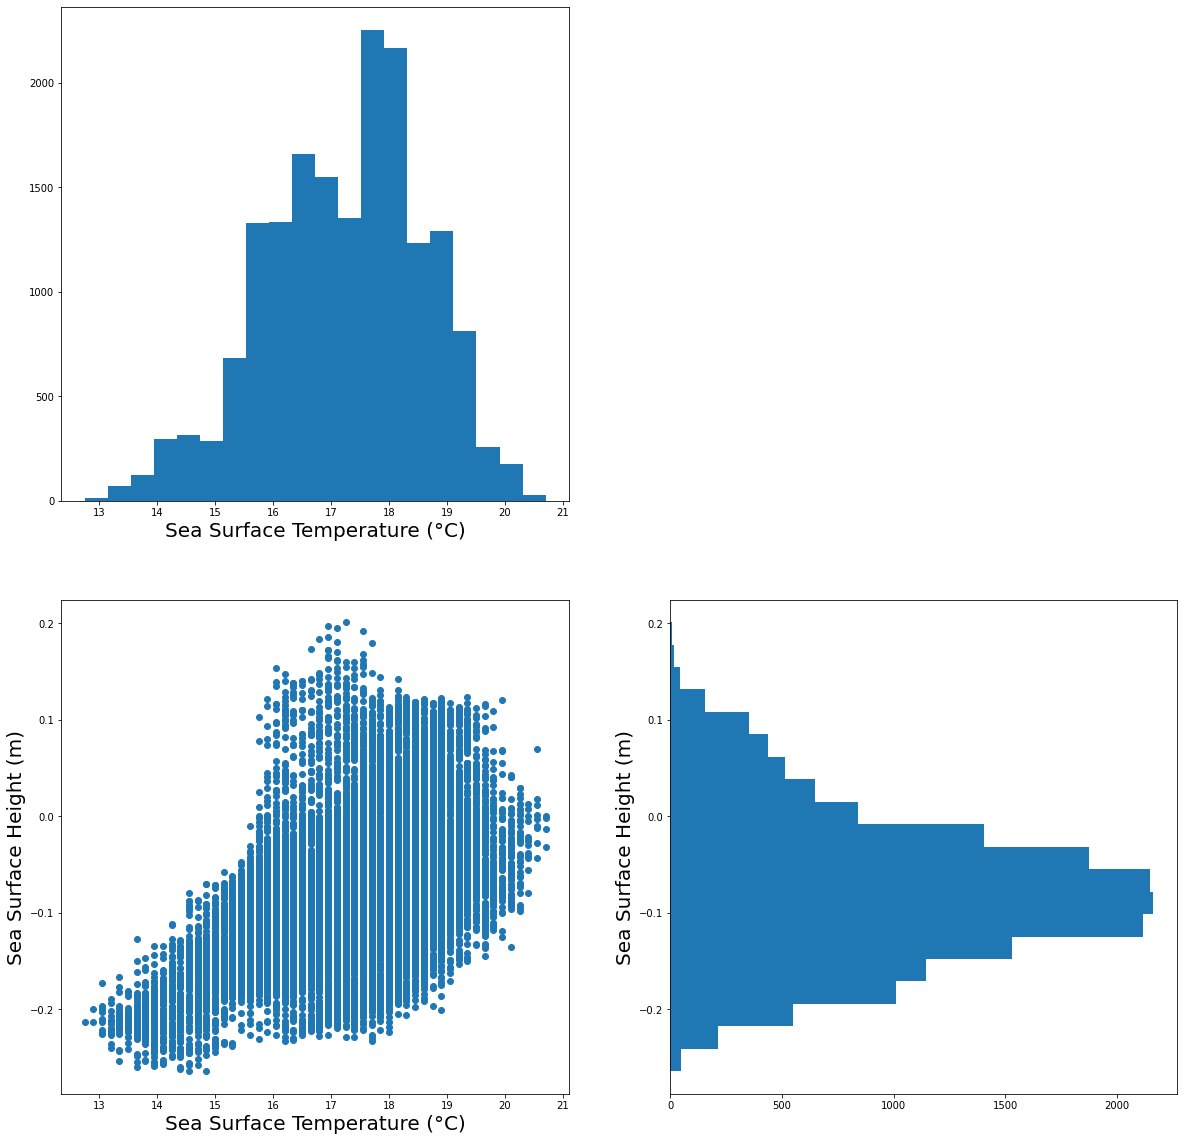

In [ ]:
# data selection
data_med=data[(data.lon>0) & (data.lon<35) & (data.lat>30) & (data.lat<45)]

# plot SST and SSH maps
sst_med_im=data_med.groupby(['lon','lat'])['sst'].mean()
ssh_med_im=data_med.groupby(['lon','lat'])['ssh'].mean()
lon_med_im=data_med.groupby(['lon','lat'])['lon'].mean()
lat_med_im=data_med.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_med_im,lat_med_im,sst_med_im,20,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_med_im,lat_med_im,ssh_med_im,20,'Sea Surface Height (m)')

# plot SST and SSH time series
sst_med_ts=data_med.groupby(['time'])['sst'].mean()
ssh_med_ts=data_med.groupby(['time'])['ssh'].mean()
time_med_ts=data_med.groupby(['time'])['time'].mean() #dropout repititions
figure()
subplot(2,1,1)
plot_ts(time_med_ts,sst_med_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_med_ts,ssh_med_ts,'-*','Sea Surface Height (m)')

# plot hist(SST), hist(SSH), SSH~SST
figure()
subplot(2,2,1)
hist(data_med.sst, 20)
xlabel('Sea Surface Temperature (°C)', size=20)
subplot(2,2,4)
hist(data_med.ssh, 20, orientation=u'horizontal')
ylabel('Sea Surface Height (m)', size=20)
subplot(2,2,3)
scatter(data_med.sst, data_med.ssh)
xlabel('Sea Surface Temperature (°C)', size=20)
ylabel('Sea Surface Height (m)', size=20)

**Remark:**

The dataset used above is small (250Mo) and corresponds only to 10 days. Now, we want to manipulate the full database of 5 years (50Go) using big data tools. This database is stored in the Google Cloud Platform.

**Part 2) Manipulation of the full database using BigQuery**

First, we have to connect to the Google Cloud Platform using the following command. You will have to enter the login "bigdataocean2020@gmail.com". Send me an email to get the password (pierre.tandeo@imt-atlantique.fr). Then, copy/paste the authentification code in the following cell.

In [ ]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

In [ ]:
from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntax in BigQuery is very similar to the pandas example given in Part 1). For instance, in the example below, we plot the mean SST map in the Mediterranean Sea over the period 2011-2015. The full 5-years dataset is stored in the BigQuery table *bdo2020.bdo2020.2011_2015*. The project is called *alert-ground-261008* (strange but you have to provide it). The result of the BigQuery request is stored in the *output* dataframe.

In [ ]:
%%bigquery --project alert-ground-261008 output
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY lon, lat

In [ ]:
# sample of the dataframe
output

lon     lat   mean_sst
0     28.375  31.875  22.542716
1     33.125  31.875  23.376095
2     33.625  31.875  23.475246
3     19.125  32.125  22.364458
4     16.625  32.375  22.497946
...      ...     ...        ...
1718   5.875  42.375  17.762432
1719   7.125  42.375  18.337212
1720   7.375  42.875  18.335980
1721  33.875  32.625  23.361062
1722  34.625  34.375  23.433105

[1723 rows x 3 columns]

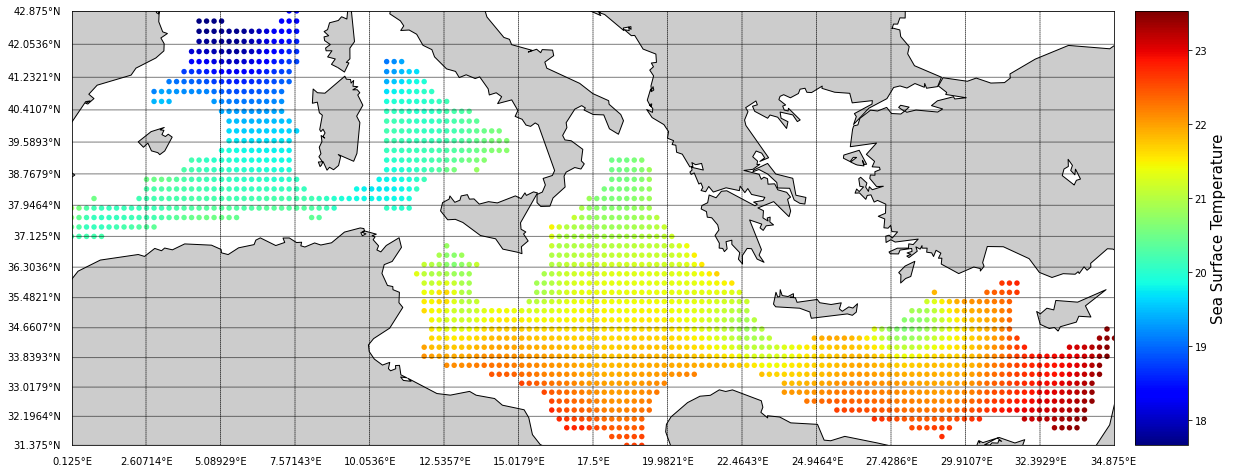

In [ ]:
plot_im(output.lon,output.lat,output.mean_sst,30,'Sea Surface Temperature')

SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

It is also possible to use Machine Learning algorithms inside BigQuery. Here you will find a complete description of the possibilities: https://cloud.google.com/bigquery-ml/docs/bigqueryml-intro?hl=fr. Another solution (easiest way of doing) is to extract a small amount of data in BigQuery and then use scikit-learn: https://scikit-learn.org/stable/.

**Important note:** the tables stored in the Google Cloud Platform are not chronologically ordered. When dealing with time series, you will thus have to use *ORDER BY time* in your BigQuery requests.

**QUESTION 1**: Compute and plot the correlation map over the period 2011-2015 between SST and SSH in the Agulhas current, between longitudes (+15,+70) and latitudes (-50,-30).

* CORR aggregation function : https://cloud.google.com/bigquery/docs/reference/standard-sql/statistical_aggregate_functions?hl=fr

In [ ]:
# We used the CORR function from BigQuery in order to calculate the correlation between SST and SSH in each longitude and latitude
%%bigquery --project alert-ground-261008 output_corr
SELECT lon,lat, CORR(ssh,sst) As corr
FROM bdo2020.bdo2020.2011_2015
WHERE lon>15 AND lon<70 AND lat>-50 AND lat<-30
GROUP BY lon,lat;

In [ ]:
df1 = pd.DataFrame(output_corr)  # we used pandas to simplify to manipulation of data

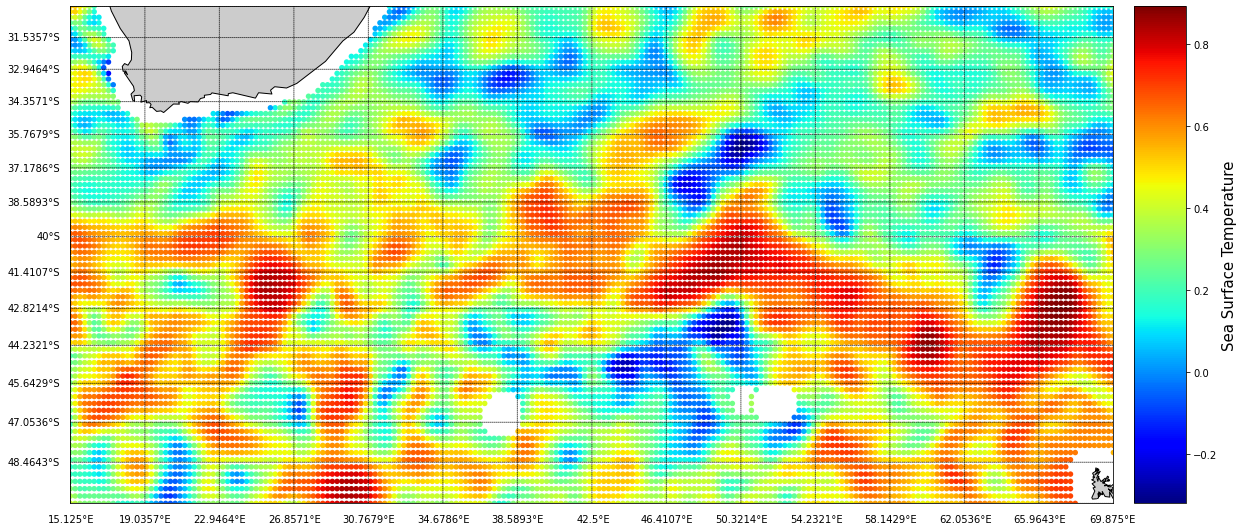

In [ ]:
# Correlation map
plot_im(df1['lon'],df1['lat'],df1['corr'],30,'Sea Surface Temperature')

**QUESTION 2**: Plot the daily mean and standard deviation time series of SST for the period 2011-2015 in the Equatorial Pacific, between longitudes (+180,+300) and latitudes (-20,+20). The mean SST time series is called the ENSO index and is used to identify El Nino and La Nina events.

* AVG aggregation function : https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators?hl=fr#avg
* STDDEV aggregation function : https://cloud.google.com/bigquery/docs/reference/standard-sql/statistical_aggregate_functions?hl=fr#stddev


In [ ]:
# We used the functions AVG and STDDEV from BigQuery to calculate the daily mean and standard deviation time series of SST
%%bigquery --project alert-ground-261008 output1
SELECT time,AVG(sst) AS mean_sst,STDDEV(sst) AS std_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY time      # daily (per day)
ORDER BY time

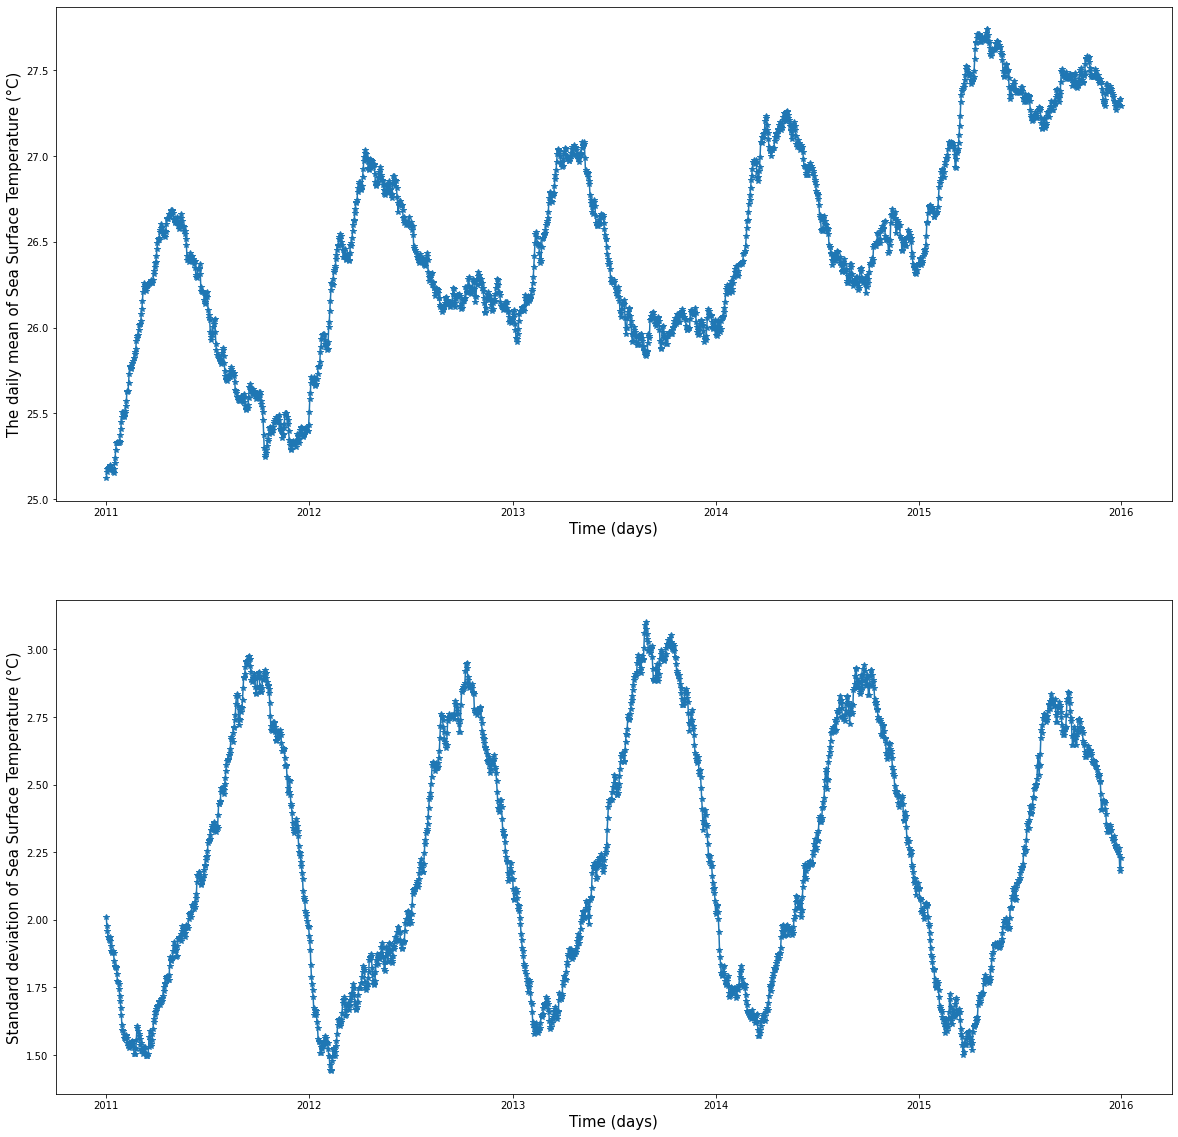

In [ ]:
# Plot the daily mean and standard deviation time series of SST
subplot(2,1,1)
plot_ts(output1.time,output1.mean_sst,'-*','The daily mean of Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(output1.time,output1.std_sst,'-*','Standard deviation of Sea Surface Temperature (°C)')

* ***Comment made by the group***:


El Niño phenomena are significant changes in the distribution of the surface water temperature of the Pacific Ocean, with major changes in climate around the world. During a year without El Niño, trade winds blow in an east-westerly direction across the tropical Pacific Ocean, causing an excess of water in the eastern Pacific Ocean, causing deep waters to rise. When El Niño happens, which occurs irregularly at intervals of 2 to 7 years, with an average of 3 to 4 years, the winds blow with less strength or even reverse direction across the central Pacific Ocean, resulting in a decrease in deep water resurgence and the accumulation of warmer than normal water on the west coast of South America. Then, in the warmer water region faster evaporation of water and cloud formation occurs. Due to cloud formation, the "Walker circulation cell" is formed. The occurrence of this phenomenon forms another, known as "resurgence", or, upwelling of cold ocean waters to the surface, continuing the cycle. El Niño is the alteration of the climate throughout the equatorial Pacific: warm and humid air masses accompany the warmer water, causing exceptional rainfall on the west coast of South America and droughts in Indonesia and Australia.

La Niña is a natural phenomenon opposite to El Niño. In the years when the phenomenon occurs, the surface water temperatures of the Central and Eastern Tropical Pacific Ocean decrease.

* ***Comment made by the group***:

During a year with El Niño, the winter is warmer than average in the central states of the United States, while in the southern states there is more rainfall; on the other hand, the Pacific Northwest states (Oregon, Washington, British Columbia) have a drier winter. The unusually hot summers in Europe and the droughts in Africa seem to be equally related to the phenomenon.

**QUESTION 3**: Compute the dealy time series of SST over the period 2011-2015 in the Pacific Ocean, south of Japan, between longitudes (+120,+145) and latitudes (+20,+40). In this region, there are a lot of typhoons and they use the energy of the sea (hot waters) to get stronger. Thus, after a typhoon, we see a rapid decrease of the SST. Plot the time series of the difference of SST between 2 consecutive days and check that the negative peaks (e.g., below -0.4°C) correspond to well known typhoons.

* AVG aggregation function : https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators?hl=fr#avg

In [ ]:
# the daily time series of SST over the period 2011-2015
%%bigquery --project alert-ground-261008 daily_sst

SELECT time,AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>120 AND lon<145 AND lat>+20 AND lat<40
GROUP BY time
ORDER BY time


In [ ]:
# pandas dataframes
data1 = pd.DataFrame(daily_sst);
data2 = pd.DataFrame(daily_sst);

* drop pandas :https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
* In order to calculate the difference, we created two shifted dataframes, then we subtracted them from each other.

In [ ]:
# we dropped first row (first day)
data1 = data1.drop(0)
data1

# we dropped last row (last day)
data2= data2.drop(len(data2)-1)
data2

time   mean_sst
0     734138.0  20.681954
1     734139.0  20.496030
2     734140.0  20.455747
3     734141.0  20.402332
4     734142.0  20.315408
...        ...        ...
1820  735958.0  21.972127
1821  735959.0  21.959162
1822  735960.0  21.819795
1823  735961.0  21.654470
1824  735962.0  21.683953

[1825 rows x 2 columns]

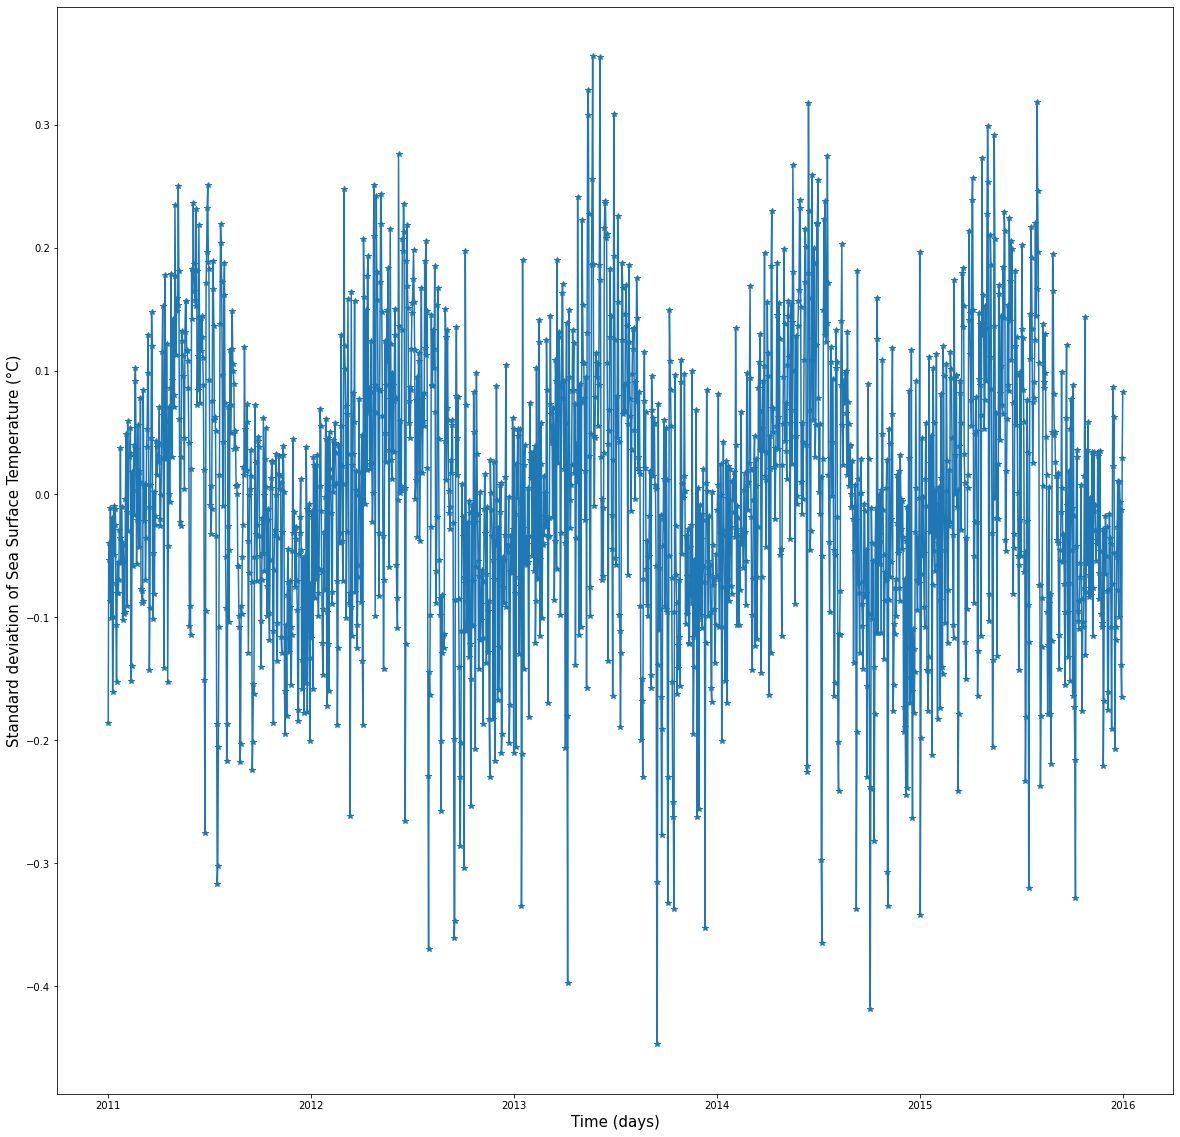

In [ ]:
# Plot the time series of the difference of SST
a=np.array(data1['mean_sst']) - np.array(data2['mean_sst'])
plot_ts(data1['time'],a,'-*','Standard deviation of Sea Surface Temperature (°C)')


 **Observations:**
* ==> The first negative peak (2013) correspond to Haiyan typhoon.
      link: https://fr.wikipedia.org/wiki/Typhon_Haiyan
* ==> The second negative peak (2014) correspond to Nuri typhoon.
      link: https://en.wikipedia.org/wiki/Typhoon_Nuri

**Part 3) Combination of BigQuery and scikit-learn**

Now, we will extract data using BigQuery and apply regressions (using scikit-learn) on these extracted data.

Note that there is another way to use machine learning algorithms (like the linear regression) in BigQuery, but this solution is difficult to implement: I suggest to use the classic one (i.e., using scikit-learn).

**QUESTION 4**: Model the daily mean SST in the Mediterranean Sea using a linear tendancy and a one-year seasonal cycle such that: $SST(t)=\alpha_0 + \alpha_1 t + \alpha_2 sin(2\pi\omega t) + \alpha_3 cos(2\pi\omega t)$, with $\omega=\frac{1}{365}$. Then, plot the raw time series and the one produced by the model. Finally, plot the autocorrelation function of the residuals (difference between the raw time series and the estimation made by the model).

In [ ]:
# We used the classic method using scikit-learn

%%bigquery --project alert-ground-261008 output_regression
SELECT time, AVG(sst) AS mean_sst, COS(2*3.14*(1/365)*time) AS cos,  SIN(2*3.14*(1/365)*time) AS sin
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY time
ORDER BY time



==> Here we added the cos and sin columns in order to train a model on these additional columns

* LinearRegression : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
import numpy as np

# Features
data= pd.DataFrame(np.asarray(output_regression.time),columns=['time'])
data['cos'] = np.asarray(output_regression.cos)
data['sin'] = np.asarray(output_regression.sin)

#target
target = output_regression.mean_sst

In [ ]:
# train the model
linear_regression = LinearRegression()
linear_regression.fit(data, target)

# predict
target_predicted = linear_regression.predict(data)

In [ ]:
# metrics
print(
  'mean_squared_error : ', mean_squared_error(target, target_predicted))
print(
  'mean_absolute_error : ', mean_absolute_error(target, target_predicted))

mean_squared_error :  0.36674797302424456
mean_absolute_error :  0.4723309915230419


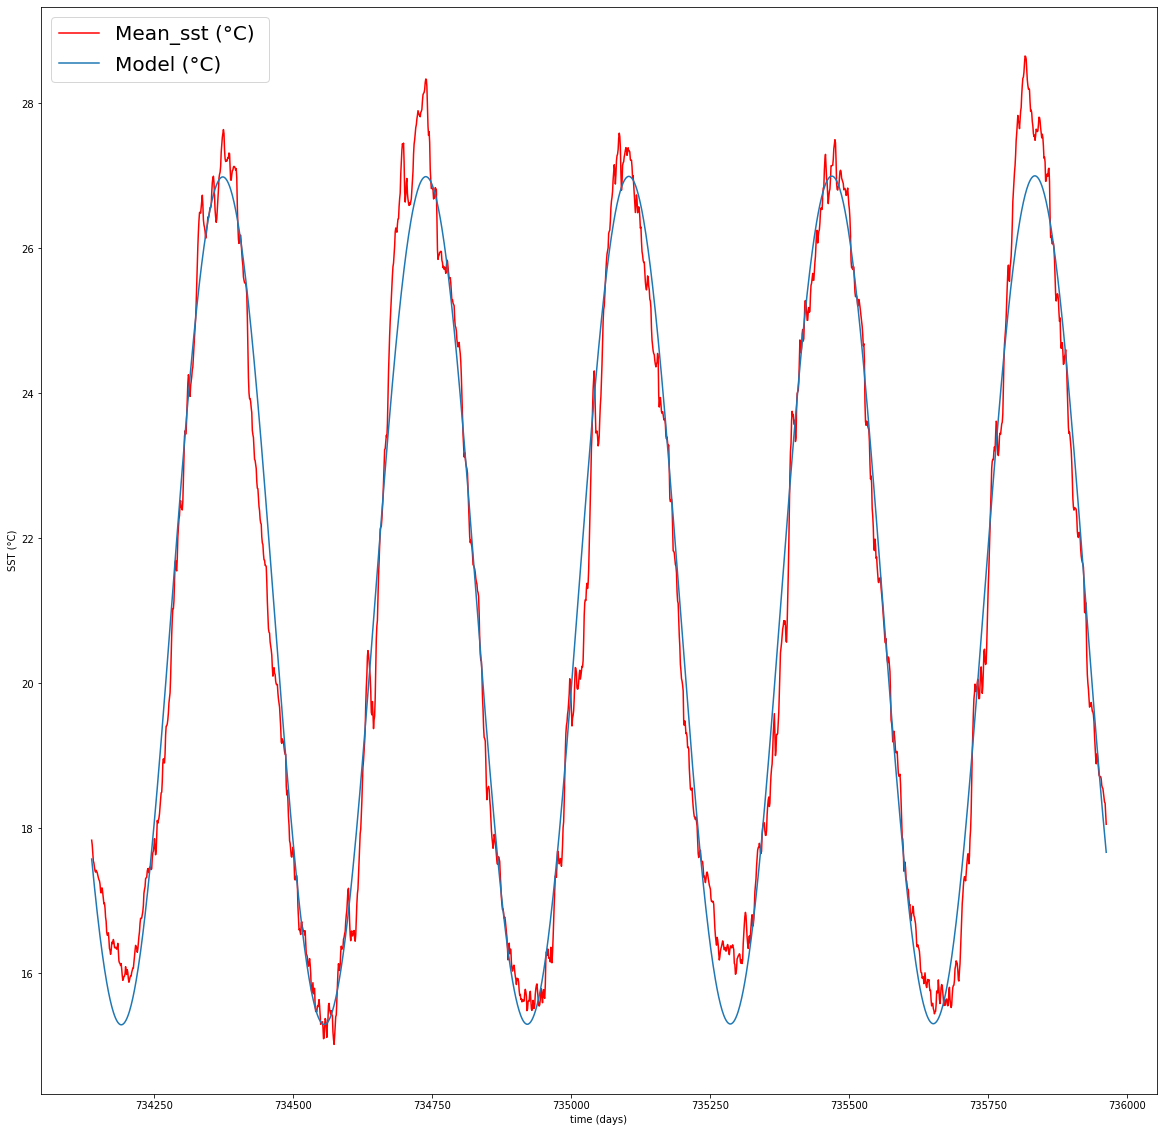

In [ ]:
import matplotlib.pyplot as plt

#plot mean sst in red
plt.plot(output_regression.time, output_regression.mean_sst,'r')
#plot predicted sst in blue
plt.plot(output_regression.time, target_predicted)
xlabel('time (days)')
ylabel('SST (°C)')
legend(['Mean_sst (°C) ', 'Model (°C)'], prop={'size': 20})


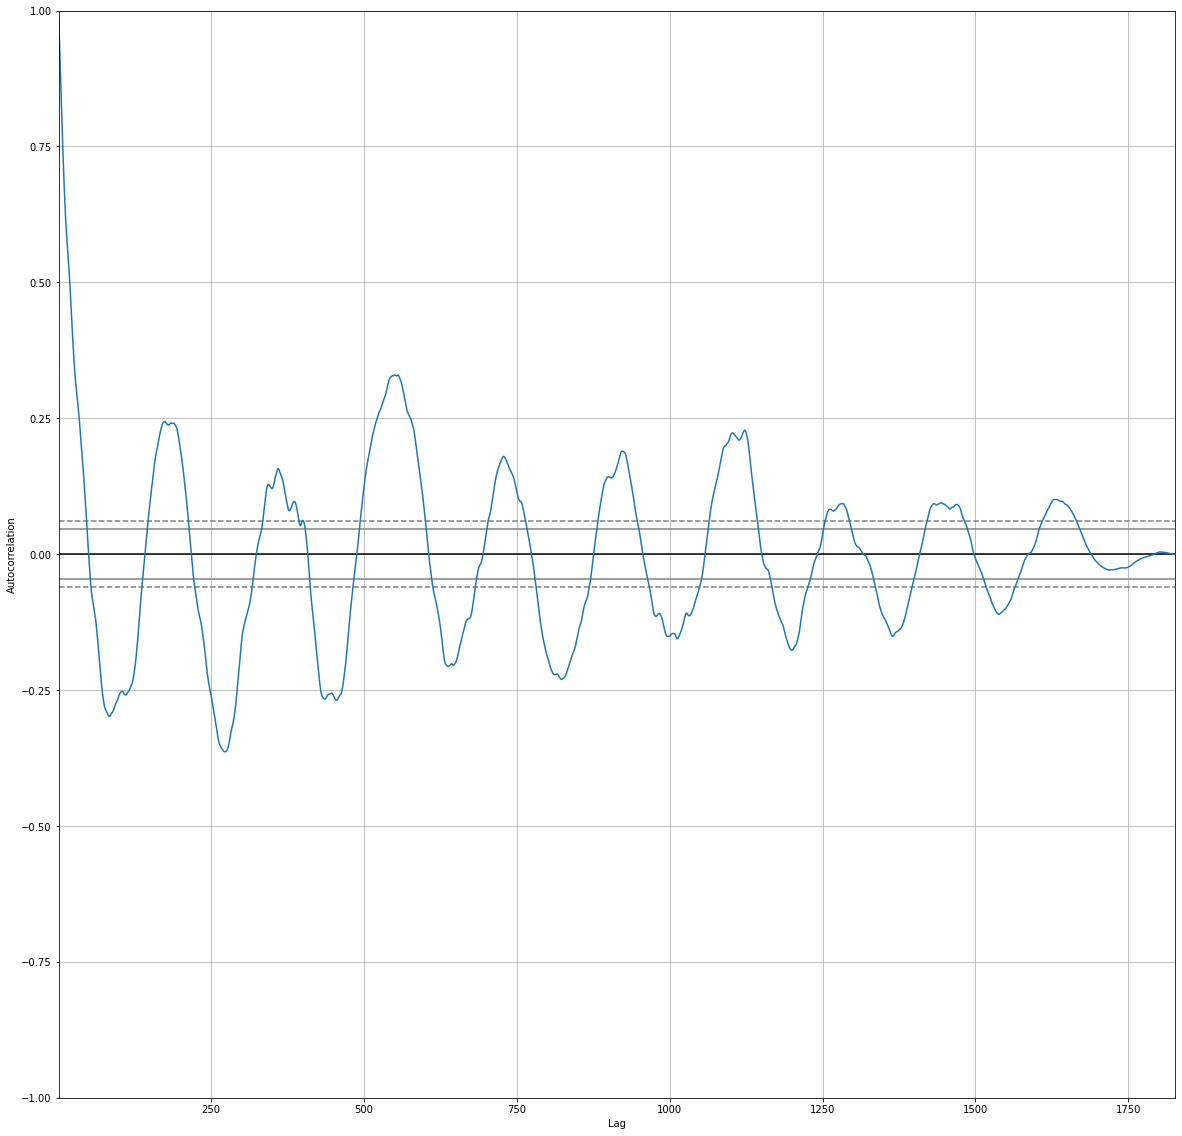

In [ ]:
# residual sst data
residual_sst_data=pd.DataFrame(np.asarray(output_regression.mean_sst- target_predicted),columns=['residual'])

#plot correlation of residual sst
x = pd.plotting.autocorrelation_plot(residual_sst_data)
#np.correlate(residual_sst_data, residual_sst_data, "same")

==> The autocorrelation function of the residuals

**QUESTION 5**: Compute the SSH difference between the first day in 2011 and the last day in 2015 for each location in the globe. Then, plot the map of this SSH difference: it shows the sea level rise. Finally, adjust a regression to model the tendancy of the global mean sea level rise (averaged over all the location) and plot the prediction for the horizon 2100.

In [ ]:
# we used a join method on order to find the ssh corresnding to the first day of 2011
%%bigquery --project alert-ground-261008 output_time
SELECT T2.lon, T2.lat, T2.ssh
FROM bdo2020.bdo2020.2011_2015 as T2
INNER JOIN (SELECT lon,lat,MIN(time) as first_day
FROM bdo2020.bdo2020.2011_2015
group by lon , lat) as T ON T.first_day=T2.time and T.lon=T2.lon AND T.lat=T2.lat

In [ ]:
# we used a join method on order to find the ssh corresnding to the last day of 2015
%%bigquery --project alert-ground-261008 output_time_max
SELECT T2.lon, T2.lat, T2.ssh
FROM bdo2020.bdo2020.2011_2015 as T2
INNER JOIN (SELECT lon,lat,MAX(time) as last_day
FROM bdo2020.bdo2020.2011_2015
group by lon , lat) as T ON T.last_day=T2.time and T.lon=T2.lon AND T.lat=T2.lat


Geostationary, Orthographic or Azimuthal equidistant basemap

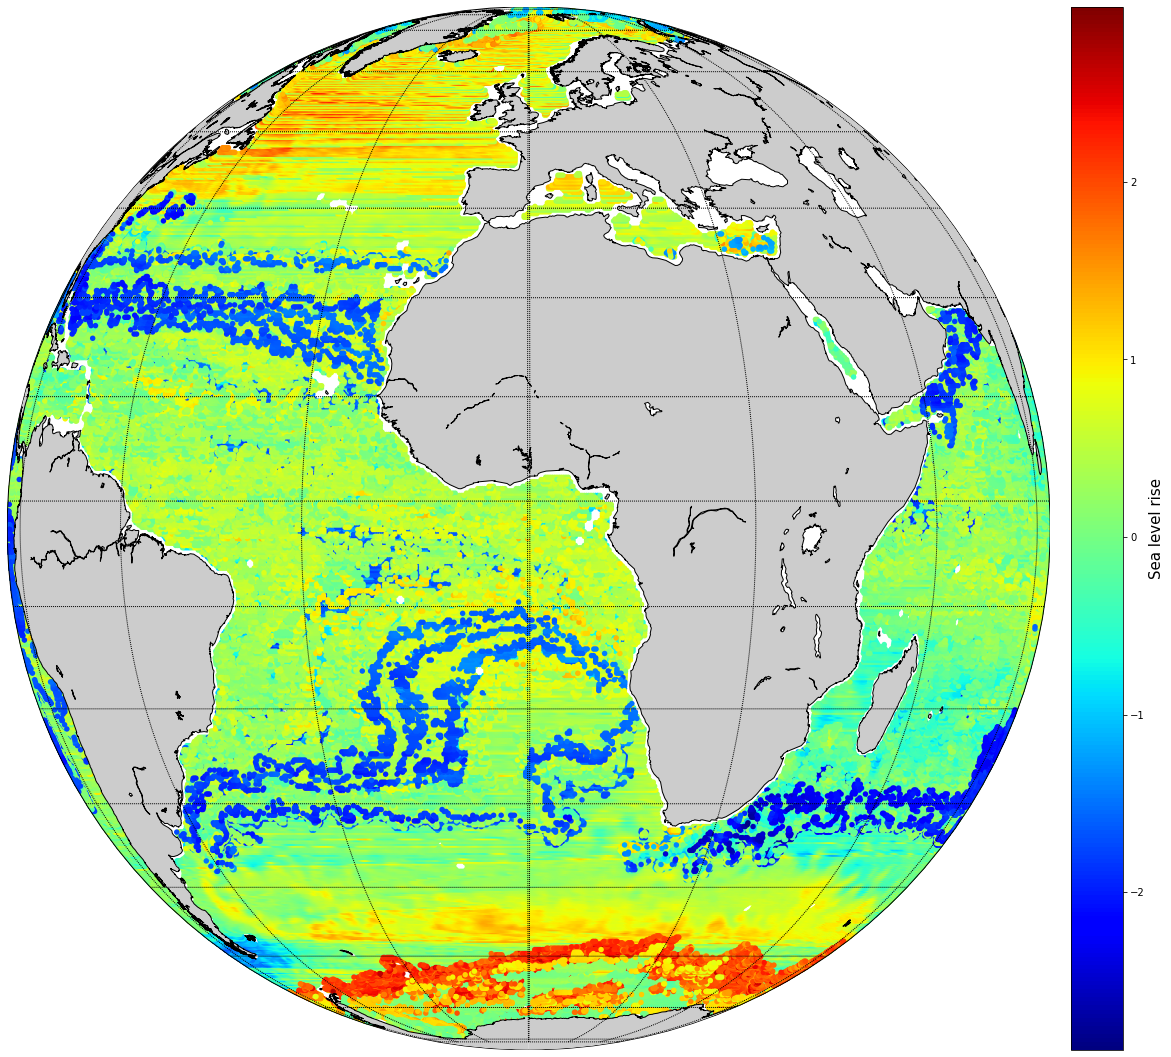

In [ ]:
plot_im(output_time.lon,output_time.lat,output_time_max.ssh-output_time.ssh,30,'Sea level rise')

* Second part of question 5 :

In [ ]:
# We will predict the daily global average ssh for 2016 to 2100, so we extracted for each day from 2010 to 2015, the global average ssh using bigquery.
%%bigquery --project alert-ground-261008 avg_ssh_time
SELECT time,AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.2011_2015
GROUP BY time # daily average
ORDER BY time


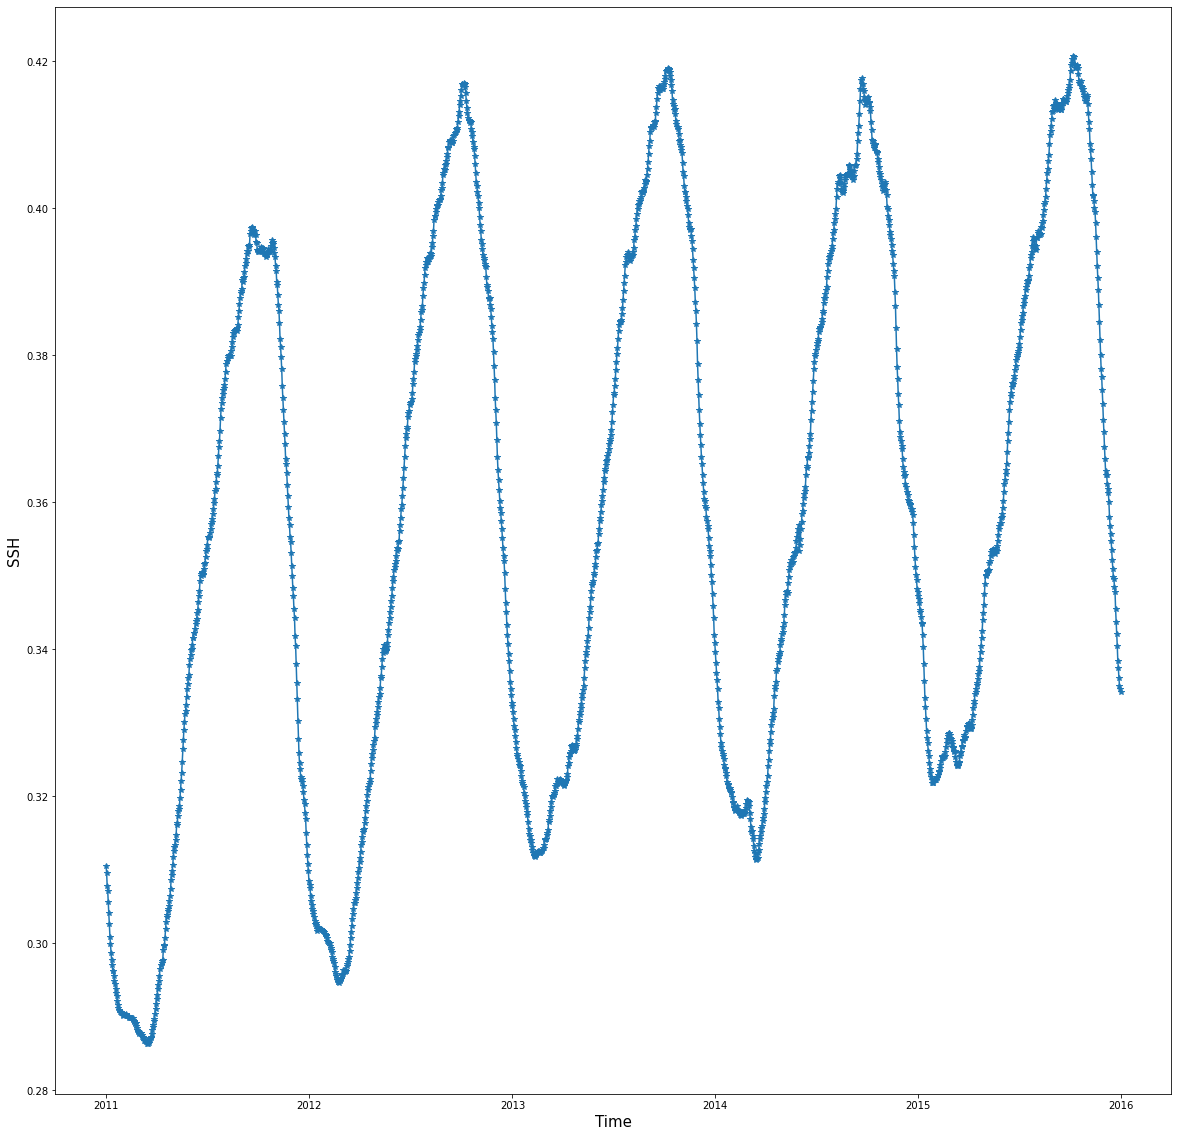

In [ ]:
plot_ts(avg_ssh_time.time,avg_ssh_time.mean_ssh,'-*','SSH') # plot the daily average ssh from 2010 to 2015


* In this part of question, we used a GaussianProcessRegressor with Linear kernel to predict the average of SSh for the year 2100
* GaussianProcessRegressor :

 https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html




In [ ]:
# imports GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,ConstantKernel

In [ ]:
df = pd.DataFrame(avg_ssh_time) # we use pandas in order to simply the manipulation of data

base = df.at[len(df)-1,'time'] # last day in the previous data (last day in 2015)

date_list = np.array([base + x for x in range(31413)]).reshape(-1,1) # list of days intil 2100 starts from last day in 2015

gp = GaussianProcessRegressor(kernel = WhiteKernel() + DotProduct() ) # definition of our GaussianProcessRegressor model with linear kernel

gp.fit(np.array(df['time']).reshape(-1,1),np.array(df['mean_ssh']).reshape(-1,1)) # fit the model on previous data

GaussianProcessRegressor(kernel=WhiteKernel(noise_level=1) + DotProduct(sigma_0=1))

In [ ]:
yPred,sigma = gp.predict(np.array(date_list),return_std=True) # make a prediction on new data (from 2016 to 2100)

In [ ]:
number_days_first_2100 = 767010 # first day of 2100
number_days_final_2100 = 767374 # last day of 2100
number_days_last_day_2015 = int(df.at[len(df)-1,'time']) # last day of 2015

first_day_2100_index = list(date_list).index(number_days_first_2100) # first method to extract the index of first day of 2100 in the list of new days
last_day_2100_index = list(date_list).index(number_days_final_2100) # first method to extract the index of last day of 2100 in the list of new days

first_day_2100_index = number_days_first_2100-number_days_last_day_2015 # second method
last_day_2100_index = number_days_final_2100-number_days_last_day_2015 # second method

list_preds_2100 = yPred[first_day_2100_index:last_day_2100_index] # all predictions for 2100

ssh_average_2100 = np.mean(list_preds_2100) # average on all predictions for 2100
interval_2100 = [np.min(list_preds_2100),np.max(list_preds_2100)] # [min, max] of all predictions for 2100

print('global ssh average for 2100 :' ,ssh_average_2100)
print('ssh interval for 2100 : [min, max] : ', interval_2100)

global ssh average for 2100 : 0.36460024445921513
ssh interval for 2100 : [min, max] :  [0.3585700988769531, 0.36968231201171875]


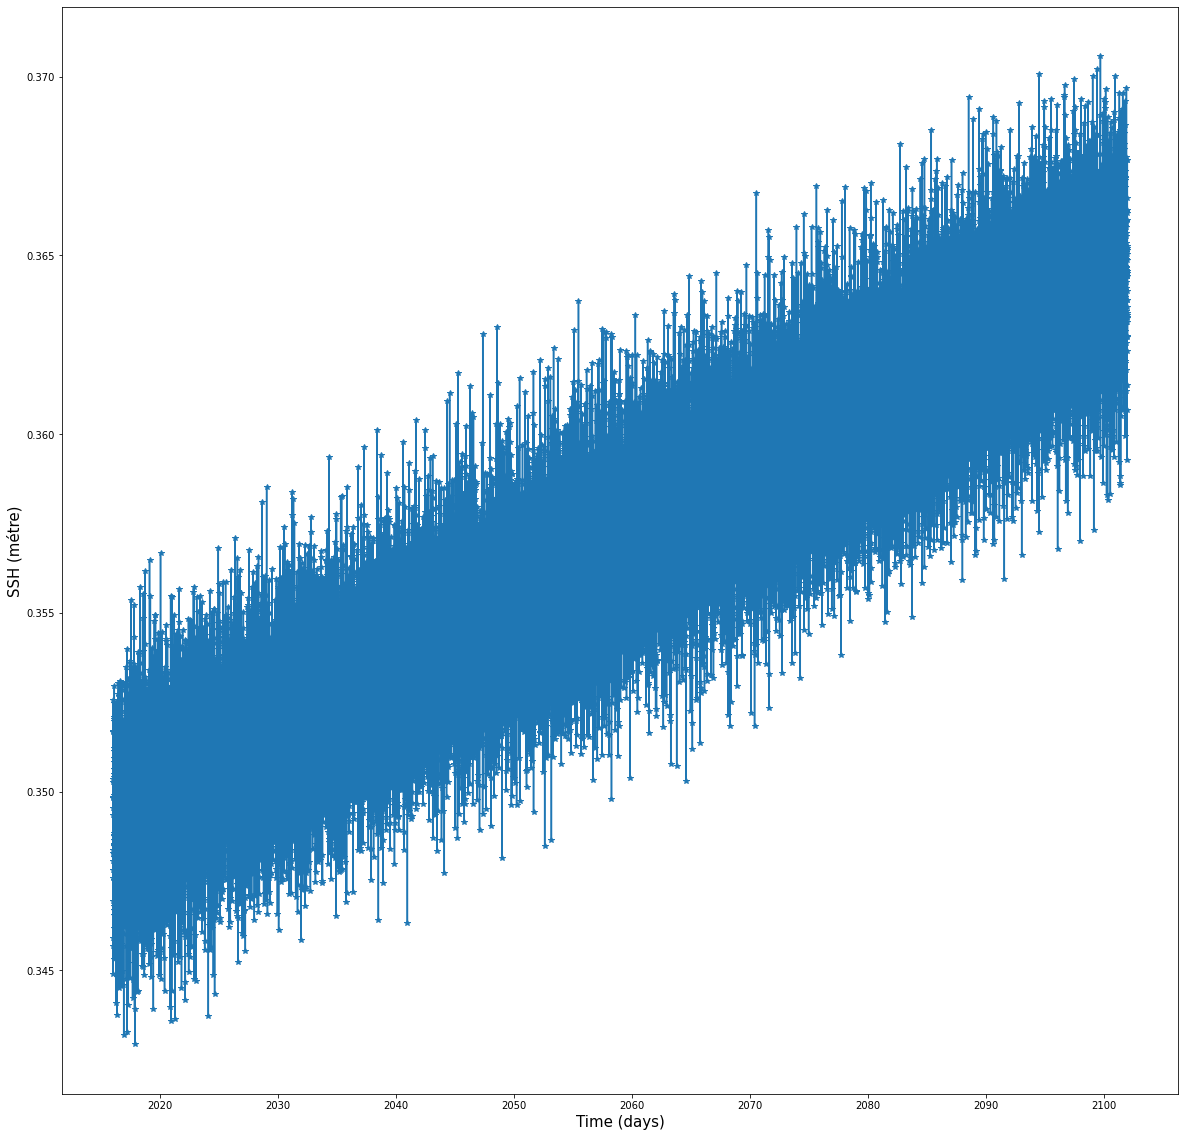

In [ ]:
plot_ts(date_list[:],yPred[:],'-*','SSH (métre)') # plot the predictions from 2016 to 2100

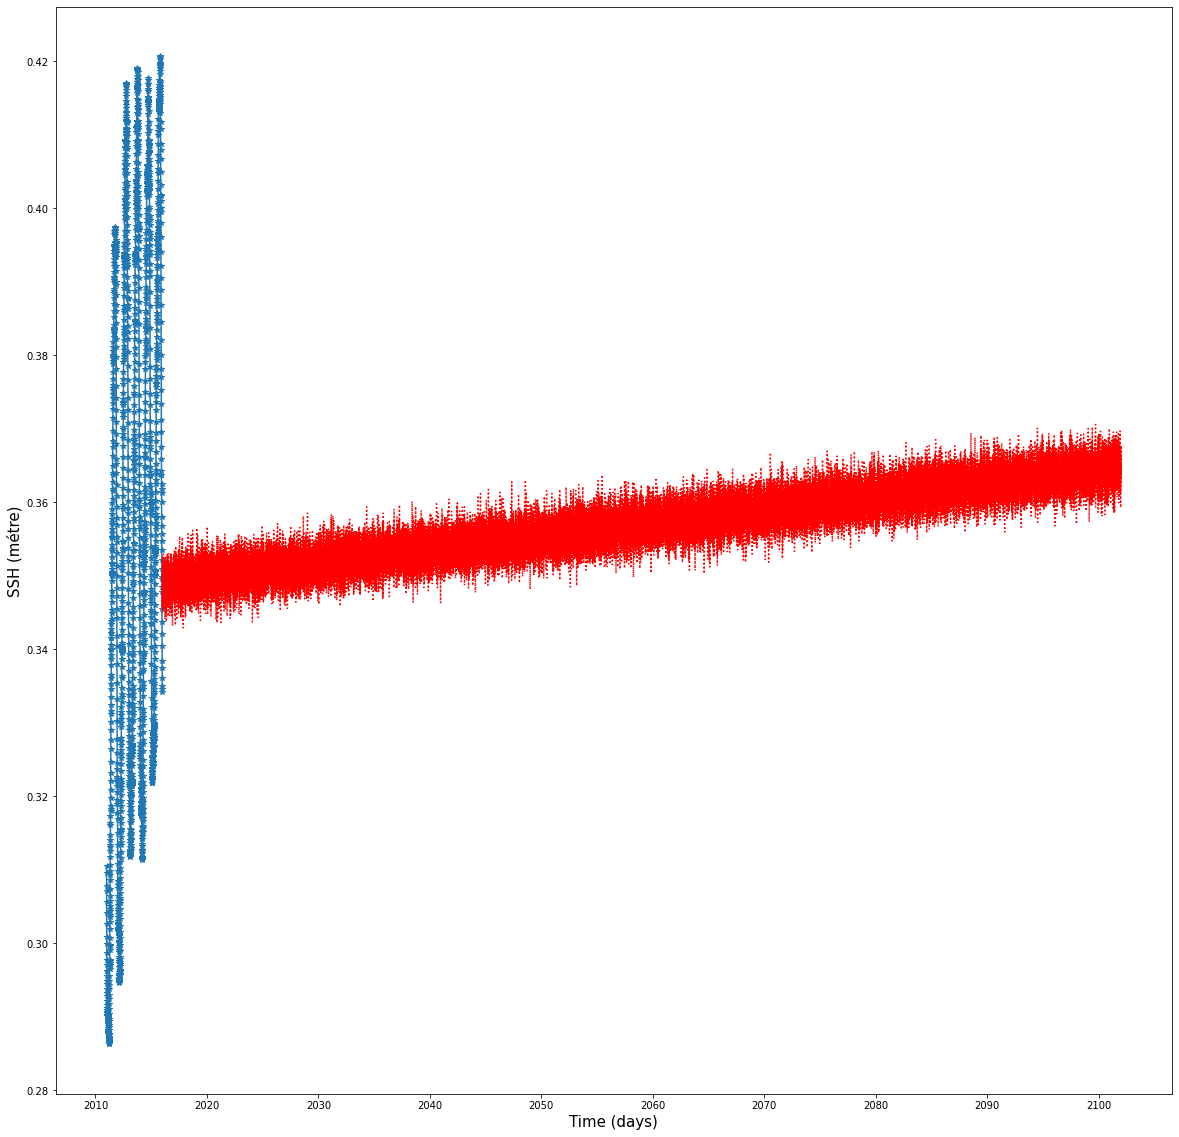

In [ ]:
plt.figure()
plot_ts(avg_ssh_time.time,avg_ssh_time.mean_ssh,'-*','SSH (métre)') # plot average ssh from 2010 to 2015
plt.plot(date_list,yPred, 'r:') # plot the predictions of average from 2016 to 2100



```
# Ce texte est au format code
```

==> We can notice the linear shape as we used a linear kernel with GaussianProcessRegressor to make our predictions for the year 2100.

We found a global ssh average equal to : 0.36525980980841666
and an interval : [0.3600196838378906, 0.3707084655761719]

Predicting the SSH by 2100 with a linear fit is very inaccurate though, as the phenomenon is inherently non-linear and sped up by many other non-linear factors.